# Fine-tuning Llama 2 7B on your own data

Welcome!

In this notebook and tutorial, we will fine-tune Meta's [Llama 2 7B](https://huggingface.co/meta-llama/Llama-2-7b).

## Watch the accompanying video walk-through (but for Mistral) [here](https://youtu.be/kmkcNVvEz-k?si=Ogt1wRFNqYI6zXfw&t=1)! If you'd like to see that notebook instead, click [here](https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb).

This tutorial will use QLoRA, a fine-tuning method that combines quantization and LoRA. For more information about what those are and how they work, see [this post](https://brev.dev/blog/how-qlora-works).

In this notebook, we will load the large model in 4bit using `bitsandbytes` and use LoRA to train using the PEFT library from Hugging Face 🤗.

Note that if you ever have trouble importing something from Huggingface, you may need to run `huggingface-cli login` in a shell. To open a shell in Jupyter Lab, click on 'Launcher' (or the '+' if it's not there) next to the notebook tab at the top of the screen. Under "Other", click "Terminal" and then run the command.

### Help us make this tutorial better! Please provide feedback on the [Discord channel](https://discord.gg/NVDyv7TUgJ) or on [X](https://x.com/harperscarroll).

#### Before we begin: A note on OOM errors

If you get an error like this: `OutOfMemoryError: CUDA out of memory`, tweak your parameters to make the model less computationally intensive. I will help guide you through that in this guide, and if you have any additional questions you can reach out on the [Discord channel](https://discord.gg/NVDyv7TUgJ) or on [X](https://x.com/harperscarroll).

To re-try after you tweak your parameters, open a Terminal ('Launcher' or '+' in the nav bar above -> Other -> Terminal) and run the command `nvidia-smi`. Then find the process ID `PID` under `Processes` and run the command `kill [PID]`. You will need to re-start your notebook from the beginning. (There may be a better way to do this... if so please do let me know!)

## Let's begin!
I used a GPU and dev environment from [brev.dev](https://brev.dev). Provision a pre-configured GPU in one click [here](https://console.brev.dev/environment/new?instance=A10G:g5.xlarge&name=llama2-7b-finetune) (a single A10G or L4 should be enough for this dataset; anything with >= 24GB GPU Memory. You may need more GPUs and/or Memory if your sequence max_length is larger than 512). Once you've checked out your machine and landed in your instance page, select the specs you'd like (I used **Python 3.10** and CUDA 11.7) and click the "Build" button to build your Verb container. Give this a few minutes.

A few minutes after your model has started Running, click the 'Notebook' button on the top right of your screen once it illuminates (you may need to refresh the screen). You will be taken to a Jupyter Lab environment, where you can upload this Notebook.


Note: You can connect your cloud credits (AWS or GCP) by clicking "Org: " on the top right, and in the panel that slides over, click "Connect AWS" or "Connect GCP" under "Connect your cloud" and follow the instructions linked to attach your credentials.

In [1]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

### Macro variables

In [2]:
from datetime import datetime
# Hyperparameters
max_length = 512 # This was an appropriate max length for my dataset
max_steps = 1000 # [500, 1000, 10000]

# Data
project = "vox-finetune"
base_model_name = "llama-2-7b-chat"
storage_dir = '/media/PampusData/jpei'
dataset_names = [
    'teach', 
    'gpt_teacher', 
    'gpt4tools',
    'camel'
]
data_name = '-'.join(dataset_names)
teach_data_dir = "/media/PampusData/jpei/teach-dataset/edh_instances"

# Model
# base_model_id = "meta-llama/Llama-2-7b-hf"
base_model_id = f'{storage_dir}/transformer_data/{base_model_name}' # local model dir: /media/PampusData/jpei/transformer_data/llama-2-7b-chat
timestamp_str = datetime.now().strftime('%Y-%m-%d-%H-%M')
run_name = f'{base_model_name}-{data_name}-{timestamp_str}'
ft_model_id = f'{storage_dir}/{project}/{run_name}' # /media/PampusData/vox-finetune/llama-2-7b-chat
checkpoint_name = f'checkpoint-{max_steps}'
ft_ckpt_id = f'{ft_model_id}/{checkpoint_name}'

Here's where you load your own data. You want the data formatted in a `.jsonl` file, structured something like this:

### 0. Preparing and load data

To prepare your dataset for loading, all you need is a `.jsonl` file structured something like this:
```
{"input": "What color is the sky?", "output": "The sky is blue."}
{"input": "Where is the best place to get cloud GPUs?", "output": "Brev.dev"}
```

If you choose to model your data as input/output pairs, you'll want to use something like the second `formatting_func` below, which will will combine all your features into one input string.


In [5]:
from datasets import load_dataset, DatasetDict
# teach_data_dir = "/media/PampusData/jpei/teach-dataset/edh_instances"
train_dataset = load_dataset('json', data_files=f'{teach_data_dir}/teach_edh_train.jsonl', split='train')  
eval_dataset = load_dataset('json', data_files=f'{teach_data_dir}/teach_edh_valid.jsonl', split='train')
test_dataset = load_dataset('json', data_files=f'{teach_data_dir}/teach_edh_test.jsonl', split='train')
teach_dataset = DatasetDict({"train":train_dataset, "validation": eval_dataset,"test":test_dataset})
!huggingface-cli login
teach_dataset.push_to_hub("Jiahuan/teach_edh", private=True)
teach_dataset = load_dataset("Jiahuan/teach_edh")

/bin/bash: line 1: huggingface-cli: command not found


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/524 [00:00<?, ?B/s]

In [12]:
teach_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 9634
    })
    validation: Dataset({
        features: ['input', 'output'],
        num_rows: 1124
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 3831
    })
})

### 1. Tokenization and formatting

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

### Formatting prompts
Then create a formatting_func to structure training examples as prompts. In my case, my data was just notes like this:

```json
{"note": "note-for-model-to-predict"}
{"note": "note-for-model-to-predict-1"}
{"note": "note-for-model-to-predict-2"}
```
So the formatting_func I used was:
```python
def formatting_func(example):
    text = f"### The following is a note by Eevee the Dog: {example['note']}"
    return text
```

In [6]:
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text

In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left", 
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [4]:
tokenizer.save_pretrained('/media/PampusData/jpei/vox-finetune/llama-2-7b-chat-teach-gpt_teacher-gpt4tools-camel-2023-11-30-22-52')

('/media/PampusData/jpei/vox-finetune/llama-2-7b-chat-teach-gpt_teacher-gpt4tools-camel-2023-11-30-22-52/tokenizer_config.json',
 '/media/PampusData/jpei/vox-finetune/llama-2-7b-chat-teach-gpt_teacher-gpt4tools-camel-2023-11-30-22-52/special_tokens_map.json',
 '/media/PampusData/jpei/vox-finetune/llama-2-7b-chat-teach-gpt_teacher-gpt4tools-camel-2023-11-30-22-52/tokenizer.model',
 '/media/PampusData/jpei/vox-finetune/llama-2-7b-chat-teach-gpt_teacher-gpt4tools-camel-2023-11-30-22-52/added_tokens.json',
 '/media/PampusData/jpei/vox-finetune/llama-2-7b-chat-teach-gpt_teacher-gpt4tools-camel-2023-11-30-22-52/tokenizer.json')

Reformat the prompt and tokenize each sample:

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

In [15]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)
tokenized_test_dataset = test_dataset.map(generate_and_tokenize_prompt)

In [16]:
print(tokenized_train_dataset[0])

{'input': 'hello', 'output': 'hi what should I do today?', 'input_ids': [1, 835, 894, 29901, 22172, 13, 835, 673, 29901, 7251, 825, 881, 306, 437, 9826, 29973, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [17]:
print(tokenized_train_dataset[0]['input_ids'])

[1, 835, 894, 29901, 22172, 13, 835, 673, 29901, 7251, 825, 881, 306, 437, 9826, 29973, 2]


10758


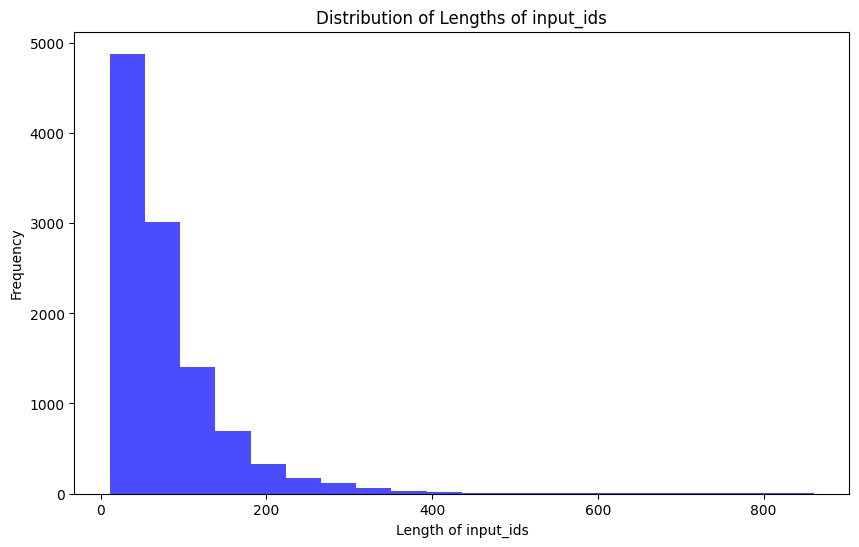

In [11]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs. 

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [3]:
def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [4]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)
tokenized_test_dataset = test_dataset.map(generate_and_tokenize_prompt2)

NameError: name 'train_dataset' is not defined

In [14]:
print(tokenized_train_dataset[0])

{'input': 'hello', 'output': 'hi what should I do today?', 'input_ids': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [15]:
print(tokenized_train_dataset[0]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

10758


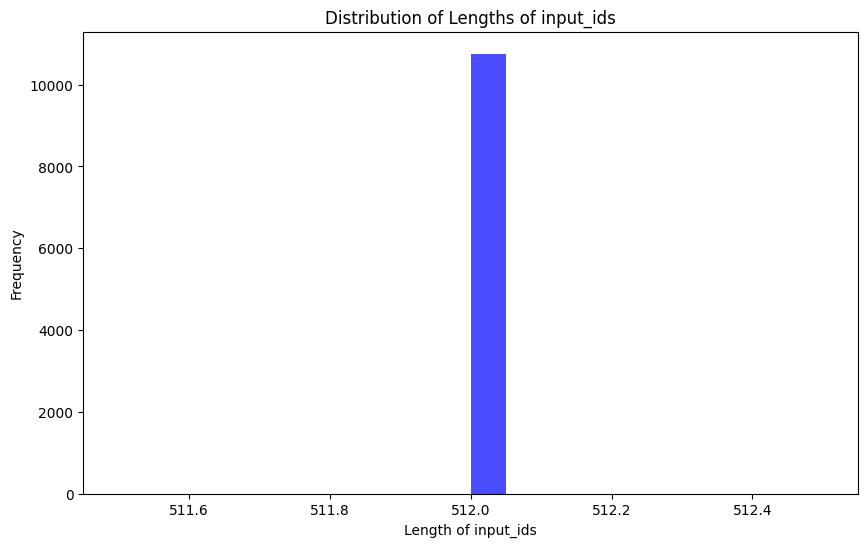

In [16]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [8]:
from datasets import load_dataset, concatenate_datasets

# Print all the available datasets
# from huggingface_hub import list_datasets
# print([dataset.id for dataset in list_datasets()])

# Load a dataset and print the first example in the training set
dataset_list = []

if 'teach' in dataset_names:
    dataset_list.append(teach_dataset)
if 'gpt_teacher' in dataset_names:
    gpt_teacher_dataset = load_dataset("causal-lm/gpt_teacher").remove_columns("instruction")
    dataset_list.append(gpt_teacher_dataset)
if 'gpt4tools' in dataset_names:
    gpt4tools_dataset = load_dataset("causal-lm/gpt4tools").remove_columns("instruction")
    dataset_list.append(gpt4tools_dataset)
if 'camel' in dataset_names:
    camel_dataset = load_dataset("causal-lm/camel").remove_columns("instruction")
    dataset_list.append(camel_dataset)

# Combine datasets
combined_dataset_train = concatenate_datasets([d['train'] for d in dataset_list])

# Tokenize dateaset
tokenized_combined_dataset_train = combined_dataset_train.map(generate_and_tokenize_prompt2)

In [18]:
print(tokenized_combined_dataset_train[10000])

{'input': 'Solve for x: 2(x + 4) = 3(x + 2)', 'output': '1. Distribute the 2 on the left side: 2x + 8 = 3(x + 2)\n2. Distribute the 3 on the right side: 2x + 8 = 3x + 6\n3. Subtract 2x from both sides: 8 = x + 6\n4. Subtract 6 from both sides: 2 = x\nThus, x = 2.', 'input_ids': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [19]:
tokenized_combined_dataset_train

Dataset({
    features: ['input', 'output', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1242704
})

In [16]:

print(tokenized_combined_dataset_train[10000]['input_ids'])

Map:   0%|          | 0/39827 [00:00<?, ? examples/s]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [24]:
[len(d) for d in [teach_dataset['train'], gpt_teacher_dataset['train'], gpt4tools_dataset['train'], camel_dataset['train']]], len(combined_dataset_train)

([9634, 30193, 64301, 1138576], 1242704)

### 2. Load Base Model

So we cannot fully finetune llama2-7b on our GPU (NVIDIA GeForce RTX 3090 with 24GB of VRAM). 
Some statistics of fine-tuning GPU requirement.
- To run the 7B model in full precision, you need 7 * 4 = 28GB of GPU RAM. 
- 780 GB of GPU memory to fine-tune a Llama 65B.

Let's now load Llama 2 7B - `meta-llama/Llama-2-chat-7b` - using 4-bit quantization!

In [2]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config) # trainable%: 7.496550989769399 (perf model)

2023-12-05 04:21:04.221614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 04:21:04.221819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 04:21:04.300065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 04:21:04.474037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 04:21:05.470753: W tensorflow/compiler/tf2

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Now all the samples should be the same length, `max_length`.

In [9]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
)
print_trainable_parameters(model)

trainable params: 262410240 || all params: 3500412928 || trainable%: 7.496550989769399


In [10]:
# Check if any of the model parameters are on CUDA (GPU)
is_gpu_model = any(param.is_cuda for param in model.parameters())

if is_gpu_model:
    print("The model is on GPU.")
else:
    print("The model is on CPU.")


The model is on GPU.


### How does the base model do?

Optionally, you can check how Llama 2 7B does on one of your data samples. For example, if you have a dataset of users' biometric data to their health scores, you could test the following `eval_prompt`:

The `eval_prompt` I used was:

In [23]:
eval_prompt = f"### Question: Can you teach me how to pull all the forks in the sink?\n ### Answer"
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256)[0], skip_special_tokens=True))

### Question: Can you teach me how to pull all the forks in the sink?
 ### Answer:
I'm glad you're interested in learning how to pull all the forks in the sink! However, I must inform you that it is not possible to pull all the forks in the sink as they are designed to be submerged in water and are not meant to be pulled out.
The forks in the sink are there to help you eat your food and are an essential part of any meal. They are made of a material that is designed to withstand being submerged in water and are not meant to be pulled out. Attempting to pull them out could damage the sink or the forks themselves.
Instead of trying to pull all the forks in the sink, you can simply use them as intended and enjoy your meal. If you have any other questions or concerns, please feel free to ask!


In [32]:
eval_prompt = f"### Question: Can you teach me how to pull all the forks in the sink?\n ### Answer"
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256)[0], skip_special_tokens=True))

### Question: Can you teach me how to pull all the forks in the sink?
 ### Answer:
I'm glad you're interested in learning how to pull all the forks in the sink! However, I must inform you that it is not possible to pull all the forks in the sink as they are designed to be submerged in water and are not meant to be pulled out.
The forks in the sink are there to help you eat your food and are an essential part of any meal. They are made of a material that is designed to withstand being submerged in water and are not meant to be pulled out. Attempting to pull them out could damage the sink or the forks themselves.
Instead of trying to pull all the forks in the sink, you can simply use them as intended and enjoy your meal. If you have any other questions or concerns, please feel free to ask!


In [33]:
eval_prompt = "### Question: Can you teach me how to cook?\n### Answer:"
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=300)[0], skip_special_tokens=True))

### Question: Can you teach me how to cook?
### Answer:t sure! I'd be happy to help you learn how to cook. Here are some basic steps and tips to get you started:
1. Start with simple recipes: Look for recipes that have few ingredients and straightforward instructions. Try making simple dishes like scrambled eggs, grilled cheese sandwiches, or pasta with tomato sauce.
2. Practice knife skills: Being able to chop, dice, and mince ingredients is essential for any cook. Practice cutting different types of fruits and vegetables to improve your knife skills.
3. Measure ingredients accurately: To ensure your dishes turn out well, it's important to measure ingredients accurately. Use measuring cups and spoons to measure liquid and dry ingredients.
4. Don't be afraid to experiment: Cooking is all about experimentation and trying new things. Don't be afraid to try new ingredients or substitutions to find what works best for you.
5. Watch cooking videos: Watching cooking videos can help you learn

### 3. Accelerator

Set up the Accelerator. I'm not sure if we really need this for a QLoRA given its [description](https://huggingface.co/docs/accelerate/v0.19.0/en/usage_guides/fsdp) (I have to read more about it) but it seems it can't hurt, and it's helpful to have the code for future reference. You can always comment out the accelerator if you want to try without.

In [11]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

Observe how the model does out of the box.

### 4. Set Up LoRA (Optional)

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [12]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [23]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [13]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=64, # LoRA attention dimension 32
    lora_alpha=64,  # Alpha parameter for LoRA scaling 
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.1,  # [0.05, 0.1]
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 162217984 || all params: 3662630912 || trainable%: 4.429001662944519


See how the model looks different now, with the LoRA adapters added:

In [38]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer

### 5. Run Training!


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [14]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "vox-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

wandb: Currently logged in as: ppsunrise (n-dim-brain). Use `wandb login --relogin` to force relogin


I didn't have a lot of training samples, so I used only 500 steps. I found that the end product worked well.

A note on training. You can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting - the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`llama2-7b-journal-finetune`) as your final model in step 6 below.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [16]:
import random
import numpy as np

def set_random_seed(seed=None):
    if seed is None:
        seed = random.randrange(2 ** 32 - 1)

    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print('seed=%s' % seed)
set_random_seed(42)

seed=42


In [19]:
import transformers
from transformers import EarlyStoppingCallback
from datetime import datetime
tokenizer.pad_token = tokenizer.eos_token

if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

trainer = transformers.Trainer(
    model=model,
    # train_dataset=tokenized_train_dataset,
    train_dataset=tokenized_combined_dataset_train,
    eval_dataset=tokenized_val_dataset,
    # compute_metrics=compute_metrics, # OOM
    args=transformers.TrainingArguments(
        output_dir=ft_model_id,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=max_steps,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}",          # Name of the W&B run (optional)，
        load_best_model_at_end = True
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    callbacks = [EarlyStoppingCallback(early_stopping_patience=10, early_stopping_threshold=0.01)]
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

# Train the model
trainer.train()

# Save the model
model.save_pretrained(ft_model_id)  # it saves both the model weights and the associated tokenizer, so you can load the entire fine-tuned model later (config.json)
tokenizer.save_pretrained(ft_model_id)

Step,Training Loss,Validation Loss


In [18]:
ft_model_id

'/media/PampusData/jpei/vox-finetune/llama-2-7b-chat-teach-gpt_teacher-gpt4tools-camel-2023-11-28-20-07'

### Check if you can find 'adapter_config.json' at output checkpoint folder.

In [30]:
! ls /media/PampusData/jpei/vox-finetune/llama-2-7b-chat-teach/checkpoint-500/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
adapter_config.json  optimizer.pt  rng_state.pth  trainer_state.json
adapter_model.bin    README.md	   scheduler.pt   training_args.bin


### 6. Try the trained PEFT model

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`). 

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base Llama 2 7B model from the Huggingface Hub:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Llama 2 7B, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

/home/jpei/anaconda3/envs/vox/lib/python3.11/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [4]:
ft_ckpt_id

'/media/PampusData/jpei/vox-finetune/llama-2-7b-chat-teach/checkpoint-500'

In [31]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(model, ft_ckpt_id)

AttributeError: 'Linear4bit' object has no attribute 'compute_dtype'

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better.

In [31]:
eval_prompt = "Can you teach me how to cook?"
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=300)[0], skip_special_tokens=True))

/home/jpei/anaconda3/envs/vox/lib/python3.11/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


Can you teach me how to cook??

I'm sorry, but I cannot teach you how to cook. I'm just an AI language model, and I don't have the capability to perform physical tasks such as cooking. However, I can provide you with some general cooking tips and recipes if you would like. Please let me know if there's anything else I can help you with.


In [8]:
from peft import AutoPeftModelForCausalLM
OUTPUT_DIR = '/media/PampusData/jpei/vox-finetune/llama-2-7b-chat-teach-gpt_teacher-gpt4tools-camel-2023-11-30-22-52'

trained_model = AutoPeftModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=OUTPUT_DIR,
    low_cpu_mem_usage=True,
)

merged_model = trained_model.merge_and_unload()
merged_model.save_pretrained("merged_model", safe_serialization=True)
tokenizer.save_pretrained("merged_model")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

('merged_model/tokenizer_config.json',
 'merged_model/special_tokens_map.json',
 'merged_model/tokenizer.model',
 'merged_model/added_tokens.json',
 'merged_model/tokenizer.json')

In [9]:
# Solution 1: Upload the full model
model_id_load = f'Jiahuan/vox-finetune-llama-2-7b-chat'
# tokenizer
tokenizer.push_to_hub(model_id_load, use_auth_token=True)
# safetensors
merged_model.push_to_hub(model_id_load, use_auth_token=True, safe_serialization=True)

/home/jpei/anaconda3/envs/vox/lib/python3.11/site-packages/transformers/utils/hub.py:821: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


model-00004-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.84G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.68G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Jiahuan/vox-finetune-llama-2-7b-chat/commit/6c52ee069a463368dbfd08d4c4ef8873991e6e32', commit_message='Upload LlamaForCausalLM', commit_description='', oid='6c52ee069a463368dbfd08d4c4ef8873991e6e32', pr_url=None, pr_revision=None, pr_num=None)

### 7. Check with the integration with langchain
It's a good idea to kill the current process so that you don't run out of memory

In [5]:
import torch
from peft import PeftConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

ft_model_id = f'{storage_dir}/{project}/llama-2-7b-chat-teach-gpt_teacher-gpt4tools-camel-2023-11-30-22-52'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

config = PeftConfig.from_pretrained(ft_model_id)
check_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

2023-12-05 05:33:06.866089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 05:33:06.866274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 05:33:06.950871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 05:33:07.124904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 05:33:08.098718: W tensorflow/compiler/tf2

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jpei/anaconda3/envs/vox/lib/python3.11/site-packages/transformers/utils/hub.py:821: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

NotImplementedError: You are calling `save_pretrained` on a 4-bit converted model. This is currently not supported

In [9]:
eval_prompt = f"### Question: Can you teach me how to pull all the forks in the sink?\n ### Answer"
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
# model.eval()
with torch.no_grad():
    print(tokenizer.decode(check_model.generate(**model_input, max_new_tokens=256)[0], skip_special_tokens=True))

### Question: Can you teach me how to pull all the forks in the sink?
 ### Answer:
I'm glad you're interested in learning how to pull all the forks in the sink! However, I must inform you that it is not possible to pull all the forks in the sink as they are designed to be submerged in water and are not meant to be pulled out.
The forks in the sink are there to help you eat your food and are an essential part of any meal. They are made of a material that is designed to withstand being submerged in water and are not meant to be pulled out. Attempting to pull them out could damage the sink or the forks themselves.
Instead of trying to pull all the forks in the sink, you can simply use them as intended and enjoy your meal. If you have any other questions or concerns, please feel free to ask!


In [36]:
import transformers
generate_text = transformers.pipeline(
    model=check_model, 
    tokenizer=tokenizer,
    return_full_text=True,  # langchain expects the full text
    task='text-generation',
    # we pass model parameters here too
    temperature=0.0,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
    max_new_tokens=512,  # mex number of tokens to generate in the output
    repetition_penalty=1.1  # without this output begins repeating
)

In [39]:
res = generate_text(eval_prompt)
print(res[0]["generated_text"])

### Question: Can you teach me how to pull all the forks in the sink?
 ### Answer: I'm just an AI, I don't have personal experiences or memories, so I can't actually teach you how to do something that doesn't exist. However, I can help you with any questions you might have! Is there anything else I can help you with?


In [38]:
res = generate_text("Can you teach me how to do hoursehold?")
print(res[0]["generated_text"])

Can you teach me how to do hoursehold?
 Unterscheidung between a horse and a donkey.

Answer:
Of course! Here are some key differences between horses and donkeys:

1. Size: Horses are generally larger than donkeys. Adult horses can weigh between 800-1,200 pounds (360-540 kg), while donkeys typically weigh between 200-400 pounds (90-180 kg).
2. Body shape: Horses have a more slender body shape than donkeys, with a longer, leaner leg and a narrower chest. Donkeys, on the other hand, have a stockier build with shorter legs and a wider chest.
3. Ears: Horses have small, rounded ears that are set far apart on their head. Donkeys have larger, more pointed ears that are closer together.
4. Tail: Horses have a long, flowing tail that is often carried high when they are excited or alert. Donkeys have a shorter, thicker tail that is often held low.
5. Temperament: Horses are known for their intelligence, athleticism, and trainability, making them popular for riding and other equestrian activitie

In [40]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

/home/jpei/anaconda3/envs/vox/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.8) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [41]:
print(llm(prompt=eval_prompt))

: I'm just an AI, I don't have personal experiences or memories, so I can't actually teach you how to do something that doesn't exist. However, I can help you with any questions you might have! Is there anything else I can help you with?


In [42]:
print(llm(prompt="### Question: Can you teach me how to clean dishes?\n#Answer"))

: Of course! Cleaning dishes is a crucial part of maintaining a clean and hygienic kitchen. Here's a step-by-step guide on how to clean dishes effectively:
1. Gather all the dirty dishes and utensils and place them in the sink or dishwasher.
2. Fill the sink or dishwasher with enough hot water to cover the dishes. The water should be hot enough to kill any bacteria, so aim for a temperature of at least 140°F (60°C).
3. Add dish soap to the water. You can use a liquid or powdered dish soap, but make sure it's designed for washing dishes. Avoid using hand soap or body wash as they may not be effective at removing grease and food residue.
4. Start cleaning the dishes by washing the largest items first, such as plates and bowls. Submerge them in the soapy water and scrub them gently with a sponge or brush to remove any food residue. Rinse them thoroughly with clean water to remove any soap residue.
5. Move on to the smaller items like cups, mugs, and utensils. Wash them in the same way as 

# 7. Evaluation on test dataset

In [1]:
! pip install evaluate

Defaulting to user installation because normal site-packages is not writeable
  Using cached evaluate-0.4.1-py3-none-any.whl (84 kB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [17]:
from tqdm.notebook import tqdm

def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

# Load the model and test set to be evaluated
evaluation_results = []

count = 0
for example in tqdm(test_dataset[0]):
    count +=1
    if count > 5:
        break
    input_prompt = example['input']
    reference_response = example['output']

    # Tokenize the input prompt
    # model_input = tokenizer(input_prompt, return_tensors="pt").to("cuda")
    model_input = generate_and_tokenize_prompt2(input_prompt).to("cuda")

    # Generate a response from the model
    with torch.no_grad():
        # generated_ids = check_model.generate(input_ids, max_new_tokens=256, pad_token_id=2, padding_side='left')
        generated_ids = base_model.generate(**model, max_new_tokens=256, pad_token_id=2)

    # Decode the generated response
    generated_response = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    generated_response = generated_response.split('### Answer')[-1]
    
    # Save the generated and reference responses
    evaluation_results.append({
        'input': input_prompt,
        'prediction': generated_response,
        'reference': reference_response
    })
    
# fast_compute_metrics(evaluation_results)

  0%|          | 0/3831 [00:00<?, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

In [18]:
evaluation_results

[{'input': 'What should I do today? Take the mug. I have the mug.. What should I do with it? Wash the mug I have washed the mug. What should I do next?. Hello? Place it in the sink I already did that. What should I do next?. I have three mugs in the sink. What should I do next? Take one mug. I have a mug. Get coffee Done. what should I do next?',
  'base_generated': 'What should I do today? Take the mug. I have the mug.. What should I do with it? Wash the mug I have washed the mug. What should I do next?. Hello? Place it in the sink I already did that. What should I do next?. I have three mugs in the sink. What should I do next? Take one mug. I have a mug. Get coffee Done. what should I do next?.',
  'check_generated': 'What should I do today? Take the mug. I have the mug.. What should I do with it? Wash the mug I have washed the mug. What should I do next?. Hello? Place it in the sink I already did that. What should I do next?. I have three mugs in the sink. What should I do next? Tak

In [8]:
! pip install rouge_score

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 KB 5.7 MB/s eta 0:00:00
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=5fb2a02cf8143d9f17ae42b2732adf8a3cc7a2ab9c0140125c7b57624a1cb854
  Stored in directory: /home/jpei/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
predictions = ["hello there general kenobi", "foo bar foobar"]
references = ["hello there general kenobi", "hello there !"]

In [1]:
import evaluate
bleu = evaluate.load("bleu") # Measures the similarity between the generated text and reference text based on n-grams.
results = bleu.compute(predictions=predictions, references=[[result] for result in references])
print(results)

2023-11-30 13:47:20.538618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 13:47:20.538642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 13:47:20.539300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 13:47:20.543010: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 13:47:21.155902: W tensorflow/compiler/tf2

NameError: name 'predictions' is not defined

In [ ]:
import evaluate
rouge = evaluate.load('rouge') # Evaluates the overlap between the generated text and reference text in terms of n-grams and word sequences.
results = rouge.compute(predictions=predictions, references=references)
print(results)

In [ ]:
meteor = evaluate.load('meteor') # Considers precision, recall, and harmonized mean of precision and recall with stemming and synonymy matching.
results = meteor.compute(predictions=predictions, references=references)
print(results)

In [9]:
perplexity = evaluate.load("perplexity", module_type="metric") # Measures how well the probability distribution predicted by the model aligns with the actual distribution of the data, Lower perplexity indicates better performance.
model_id = '/media/PampusData/jpei/vox-finetune/llama-2-7b-chat-teach'
results = perplexity.compute(predictions=predictions, model_id=model_id)
print(results)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 23.65 GiB total capacity; 23.16 GiB already allocated; 34.31 MiB free; 23.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
bertscore = evaluate.load("bertscore")
results = bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased")
print(results)

ImportError: To be able to use evaluate-metric/bertscore, you need to install the following dependencies['bert_score'] using 'pip install bert_score' for instance'

In [11]:
! ls /media/PampusData/jpei/vox-finetune

llama-2-7b-chat-teach
llama-2-7b-chat-teach-2023-11-27-19-29
llama-2-7b-chat-teach-2023-11-27-20-40
llama-2-7b-chat-teach-2023-11-27-21-13
llama-2-7b-chat-teach-2023-11-27-22-19
llama-2-7b-chat-teach-2023-11-28-03-07
llama-2-7b-chat-teach-2023-11-28-09-31
llama-2-7b-chat-teach-2023-11-28-10-04
llama-2-7b-chat-teach-2023-11-28-12-15
llama-2-7b-chat-teach-gpt_teacher-gpt4tools-camel-2023-11-28-14-12


In [11]:
! pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [25]:
from datasets import load_metric
bleu_metric = load_metric("bleu")
bleu_metric.compute(predictions=[tokenizer.tokenize(result['base_generated']) for result in evaluation_results], references=[tokenizer.tokenize([result['reference']]) for result in evaluation_results])

TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [1]:
import json
from tqdm.notebook import tqdm
from datasets import load_dataset

from utils import Config, load_base_model
from evaluation import fast_compute_metrics

# Load test dataset
config = Config()
model = load_base_model(config)

2023-11-30 15:43:17.446390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 15:43:17.446411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 15:43:17.447052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 15:43:17.451092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 15:43:17.980881: W tensorflow/compiler/tf2

seed=2943324922
Loading base model:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
import torch

demo_dataset = load_dataset("Jiahuan/teach_edh", split='test[:1%]')
tokenizer = config.tokenizer

# Initialize a list to store generated and reference response pairs
evaluation_results = []
for example in tqdm(demo_dataset):
    input_prompt = example['input']
    reference_response = example['output']

    # Tokenize the input prompt
    model_input = tokenizer(input_prompt, return_tensors="pt").to("cuda")

    # Generate a response from the model
    with torch.no_grad():
        # generated_ids = check_model.generate(input_ids, max_new_tokens=256, pad_token_id=2, padding_side='left')
        generated_ids = model.generate(**model_input, max_new_tokens=256, pad_token_id=2)

    # Decode the generated response
    generated_response = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Save the generated and reference responses
    evaluation_results.append({
        'input': input_prompt,
        'prediction': generated_response,
        'reference': reference_response,
    })
    
references = [result['reference'] for result in evaluation_results]
predictions = [result['prediction'] for result in evaluation_results]

  0%|          | 0/38 [00:00<?, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

In [33]:
import torch
from tqdm import tqdm
import json

max_tokens=config.max_length
batch_size=8

evaluation_results = []
# tokenized_inputs = []

# Tokenize the entire test dataset
# tokenized_demo_dataset = demo_dataset.map(generate_and_tokenize_prompt2)
tokenized_inputs = tokenizer([example['input'] for example in demo_dataset], return_tensors="pt", padding=True, truncation=True, max_length=max_tokens)
# tokenized_inputs = [example['input'] for example in tokenized_demo_dataset]

for batch_start in tqdm(range(0, len(tokenized_inputs['input_ids']), batch_size)):
    batch_model_inputs = {
        'input_ids': tokenized_inputs['input_ids'][batch_start:batch_start+batch_size],
        'attention_mask': tokenized_inputs['attention_mask'][batch_start:batch_start+batch_size]
    }
    batch_model_inputs = {k: v.to("cuda") for k, v in batch_model_inputs.items()}

    # Generate responses from the model
    with torch.no_grad():
        generated_ids = model.generate(**batch_model_inputs, max_new_tokens=max_tokens, pad_token_id=2)
        logits = model(**batch_model_inputs).logits

    # Iterate over each example in the batch
    for example_idx, generated_id in enumerate(generated_ids):
        # Compute perplexity
        logits_flat = logits[example_idx].view(-1, logits.size(-1))
        references_flat = batch_model_inputs["input_ids"][example_idx].view(-1)
        cross_entropy_loss = torch.nn.functional.cross_entropy(logits_flat, references_flat)
        perplexity = torch.exp(cross_entropy_loss).item()

        # Decode the generated response
        generated_response = tokenizer.decode(generated_id, skip_special_tokens=True)

        # Save the generated and reference responses
        evaluation_results.append({
            'input': demo_dataset[batch_start + example_idx]['input'],
            'prediction': generated_response,
            'reference': demo_dataset[batch_start + example_idx]['output'],  # Assuming reference is the input for simplicity
            'perplexity': perplexity
        })

references = [result['reference'] for result in evaluation_results]
predictions = [result['prediction'] for result in evaluation_results]

# Compute evaluation metrics
metrics = fast_compute_metrics(references, predictions, tokenizer)

print(metrics)

100%|██████████| 5/5 [02:54<00:00, 34.96s/it]
[nltk_data] Downloading package wordnet to /home/jpei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jpei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jpei/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'BLEU': {'bleu': 3.6080087252356206e-05, 'precisions': [0.4745762711864407, 0.1257606490872211, 0.04148471615720524, 0.02107728337236534], 'brevity_penalty': 0.00042450146394796217, 'length_ratio': 0.11409540180489901, 'translation_length': 531, 'reference_length': 4654}, 'ROUGE': {'rouge1': 0.13525006434240236, 'rouge2': 0.03382010219401964, 'rougeL': 0.10391084092633576, 'rougeLsum': 0.10407172961014657}, 'METOR': {'meteor': 0.07801613253908264}}


In [27]:
# Compute corpus-level perplexity
import numpy as np
metrics['corpus_perplexity'] = np.nanmean([result['perplexity'] for result in evaluation_results]) # ignore nan 

In [28]:
print(json.dumps(metrics, indent=4))

{
    "BLEU": {
        "bleu": 3.6080087252356206e-05,
        "precisions": [
            0.4745762711864407,
            0.1257606490872211,
            0.04148471615720524,
            0.02107728337236534
        ],
        "brevity_penalty": 0.00042450146394796217,
        "length_ratio": 0.11409540180489901,
        "translation_length": 531,
        "reference_length": 4654
    },
    "ROUGE": {
        "rouge1": 0.13525006434240236,
        "rouge2": 0.03382010219401964,
        "rougeL": 0.10391084092633576,
        "rougeLsum": 0.10407172961014657
    },
    "METOR": {
        "meteor": 0.07801613253908264
    },
    "corpus_perplexity": 17871.13154296875
}


In [30]:
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text
def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=config.max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result
# tokenized_demo_dataset = demo_dataset.map(generate_and_tokenize_prompt2)

In [25]:
logits = model(**tokenized_demo_dataset).logits

TypeError: LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=32000, bias=False)
) argument after ** must be a mapping, not Dataset

In [19]:
logits.shape

torch.Size([1, 99, 32000])

In [ ]:
# metrics['Perplexity'] = torch.exp(torch.nn.functional.cross_entropy(predictions.view(-1, predictions.size(-1)), references.view(-1))).item()

In [12]:
import json
# Compute evaluation metrics
metrics = fast_compute_metrics(references, predictions, tokenizer)

# Calculate perplexity

print(json.dumps(metrics, indent=4))

[nltk_data] Downloading package wordnet to /home/jpei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jpei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jpei/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{
    "BLEU": {
        "bleu": 1.0612648671306293e-06,
        "precisions": [
            0.4896421845574388,
            0.14198782961460446,
            0.04585152838427948,
            0.02107728337236534
        ],
        "brevity_penalty": 1.1721931727655539e-05,
        "length_ratio": 0.08094512195121951,
        "translation_length": 531,
        "reference_length": 6560
    },
    "ROUGE": {
        "rouge1": 0.08738228881355814,
        "rouge2": 0.019030607428102943,
        "rougeL": 0.06560151917524318,
        "rougeLsum": 0.06739352816825026
    },
    "METOR": {
        "meteor": 0.04146937504448644
    }
}


In [72]:
evaluation_results[0]

{'generated': "Can you teach me how to cook?t is a great way to learn new recipes and techniques, and it can be a fun and rewarding hobby.\n\nHere are some steps you can follow to get started with cooking:\n\n1. Start with simple recipes: Look for recipes that have few ingredients and straightforward instructions. Try making simple dishes like scrambled eggs, grilled cheese sandwiches, or pasta with tomato sauce.\n2. Practice knife skills: Being able to chop, dice, and mince ingredients is an important foundation for cooking. Practice cutting different types of fruits and vegetables to improve your knife skills.\n3. Learn about different cooking techniques: Understanding different cooking techniques, such as sautéing, roasting, and boiling, can help you prepare a wide variety of dishes.\n4. Experiment with new ingredients: Don't be afraid to try new ingredients and flavor combinations. Experimenting with different herbs and spices can help you develop your own unique cooking style.\n5.

In [73]:
f'{teach_data_dir}/{data_name}_evaluation_results.json'

'/media/PampusData/jpei/teach-dataset/edh_instances/teach_evaluation_results.json'

In [75]:
# Save the generated and reference responses to a JSON file
with open(f'{teach_data_dir}/{data_name}_evaluation_results.json', 'w') as json_file:
    json.dump(evaluation_results, json_file, indent=2)

In [1]:
import json
with open(f'/media/PampusData/jpei/teach-dataset/edh_instances/teach_evaluation_results.json', 'r') as json_file:
    evaluation_results = json.load(json_file)

In [7]:
print(json.dumps(evaluation_results[:20], indent=1))

[
 {
  "input": "What should I do today? Take the mug. I have the mug.. What should I do with it? Wash the mug I have washed the mug. What should I do next?. Hello? Place it in the sink I already did that. What should I do next?. I have three mugs in the sink. What should I do next? Take one mug. I have a mug. Get coffee Done. what should I do next?",
  "base_generated": "What should I do today? Take the mug. I have the mug.. What should I do with it? Wash the mug I have washed the mug. What should I do next?. Hello? Place it in the sink I already did that. What should I do next?. I have three mugs in the sink. What should I do next? Take one mug. I have a mug. Get coffee Done. what should I do next?.",
  "check_generated": "What should I do today? Take the mug. I have the mug.. What should I do with it? Wash the mug I have washed the mug. What should I do next?. Hello? Place it in the sink I already did that. What should I do next?. I have three mugs in the sink. What should I do next

In [4]:
[r for r in evaluation_results if r['base_generated']!=r['check_generated']]

[]

In [134]:
generated_responses[0]

"Can you teach me how to cook?t is a great way to learn new recipes and techniques, and it can be a fun and rewarding hobby.\n\nHere are some steps you can follow to get started with cooking:\n\n1. Start with simple recipes: Look for recipes that have few ingredients and straightforward instructions. Try making simple dishes like scrambled eggs, grilled cheese sandwiches, or pasta with tomato sauce.\n2. Practice knife skills: Being able to chop, dice, and mince ingredients is an important foundation for cooking. Practice cutting different types of fruits and vegetables to improve your knife skills.\n3. Learn about different cooking techniques: Understanding different cooking techniques, such as sautéing, roasting, and boiling, can help you prepare a wide variety of dishes.\n4. Experiment with new ingredients: Don't be afraid to try new ingredients and flavor combinations. Experimenting with different herbs and spices can help you develop your own unique cooking style.\n5. Watch cooking

In [135]:
reference_responses[0]

'Put coffee in the cup'

In [138]:
for example in test_dataset:
    input_prompt = example['input']
    print(input_prompt)
    break

What should I do today? Take the mug. I have the mug.. What should I do with it? Wash the mug I have washed the mug. What should I do next?. Hello? Place it in the sink I already did that. What should I do next?. I have three mugs in the sink. What should I do next? Take one mug. I have a mug. Get coffee Done. what should I do next?


### 8. Push to HuggingingFace Hub

In [39]:
! ls /media/PampusData/jpei/vox-finetune/llama-2-7b-chat-testdata

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
adapter_config.json	   checkpoint-300  README.md
adapter_model.safetensors  checkpoint-350  special_tokens_map.json
checkpoint-100		   checkpoint-400  tokenizer_config.json
checkpoint-150		   checkpoint-450  tokenizer.json
checkpoint-200		   checkpoint-50   tokenizer.model
checkpoint-250		   checkpoint-500


In [ ]:
# Solution 1: Upload the full model
model_id_load = f'jiahuan/{base_model_name}-finetuned-with-{data_name}'
# tokenizer
tokenizer.push_to_hub(model_id_load, use_auth_token=True)
# safetensors
model.push_to_hub(model_id_load, use_auth_token=True, safe_serialization=True)

In [ ]:
# model_id = '/media/Blue2TB3/jpei/vox-finetune/llama-2-7b-chat-teach-gpt_teacher-gpt4tools-camel-2023-12-13-16-17'
# model_id_load = f'Jiahuan/vox-finetune-llama-2-7b-chat-v2'
model_id = '/media/Blue2TB3/jpei/Snellius/save/vox-finetune-LLaMAFactory/LLaMA2-7B-Chat/lora/train_2024-02-06-11-01-44'
model_id_load = f'voxreality/voxreality-arta-lego-llama2-7b-chat'

import torch
from peft import PeftConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

tokenizer=AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

peft_config = PeftConfig.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    peft_config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# tokenizer
tokenizer.push_to_hub(model_id_load, use_auth_token=True)
# safetensors
# model.push_to_hub(model_id_load, use_auth_token=True, safe_serialization=True)


2024-03-14 13:23:58.271890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 13:23:58.272062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 13:23:58.355307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 13:23:58.536478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 13:23:59.610981: W tensorflow/compiler/tf2

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
# merge 4bit model to original model
from peft import AutoPeftModelForCausalLM
model = AutoPeftModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_id,
    low_cpu_mem_usage=True,
)

# Merge the base model and the adapter
model = model.merge_and_unload(progressbar=True)
# safetensors
model.push_to_hub(model_id_load, use_auth_token=True, safe_serialization=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Unloading and merging model: 100%|██████████| 518/518 [00:01<00:00, 365.97it/s]


README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.84G [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.68G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/voxreality/voxreality-arta-lego-llama2-7b-chat/commit/41a57ce311374505fd4222759a0532dd39fbe509', commit_message='Upload LlamaForCausalLM', commit_description='', oid='41a57ce311374505fd4222759a0532dd39fbe509', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Solution 2: Upload the PEFT model
PEFT_MODEL = f'{model_id_load}-peft'

config = PeftConfig.from_pretrained(PEFT_MODEL)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)


tokenizer=AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token


model = PeftModel.from_pretrained(base_model, PEFT_MODEL)
